# Imports

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
from sklearn.decomposition import PCA

# Ratings

In [8]:
df = pd.read_csv(r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\ratings\s243933_image_ratings.csv")

In [9]:
values = df['Rating'].tolist()
norm_values = [(x - min(values)) / (max(values) - min(values)) for x in values]

In [11]:
range(math.floor(min(norm_values)), math.ceil(max(norm_values) + 2))

range(0, 3)

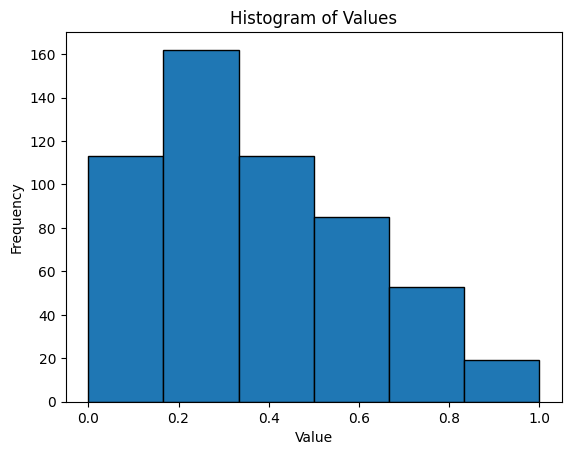

In [13]:
plt.hist(norm_values, 6, edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Values")
plt.show()

# PCA

In [16]:
# Load images
image_folder = r"C:\Users\desus\OneDrive - Danmarks Tekniske Universitet\Fall_2025\Cognitive_Modelling\Kareninator\data\preprocessed_data"

In [ ]:
# Init matrix J
J = np.array([]).reshape(0, 100*100)  # Assuming images are 64x64 pixels

In [ ]:
# Add to matrix J -> each row is a flattened image
for img_file in os.listdir(image_folder):
    img = Image.open(os.path.join(image_folder, img_file))
    img_array = np.array(img).flatten()
    J = np.vstack([J, img_array])

In [59]:
# Get the mean image and center the data
mean_J = np.mean(J, axis=0)
J_centered = J - mean_J
J_centered

array([[-79.02205882, -70.53308824, -75.        , ...,  72.95588235,
         55.40808824,  44.98161765],
       [-51.02205882, -51.53308824, -53.        , ..., -91.04411765,
        -91.59191176, -93.01838235],
       [-28.02205882, -38.53308824, -46.        , ...,   8.95588235,
        -38.59191176, -78.01838235],
       ...,
       [-36.02205882, -37.53308824, -46.        , ...,   2.95588235,
         -1.59191176,  -3.01838235],
       [ -2.02205882, -16.53308824, -34.        , ..., -39.04411765,
        -54.59191176, -52.01838235],
       [-76.02205882, -77.53308824, -79.        , ..., 136.95588235,
        135.40808824, 133.98161765]])

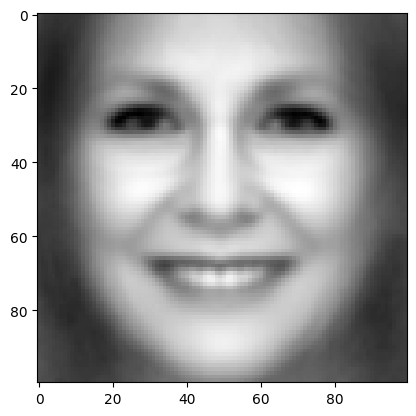

In [64]:
# Plot mean image
plt.imshow(mean_J.reshape(100, 100), cmap='gray');

In [112]:
# Do PCA on the centered data
pca = PCA(n_components=100)
scores = pca.fit_transform(J_centered)
components = pca.components_

Text(0, 0.5, 'Cumulative Explained Variance')

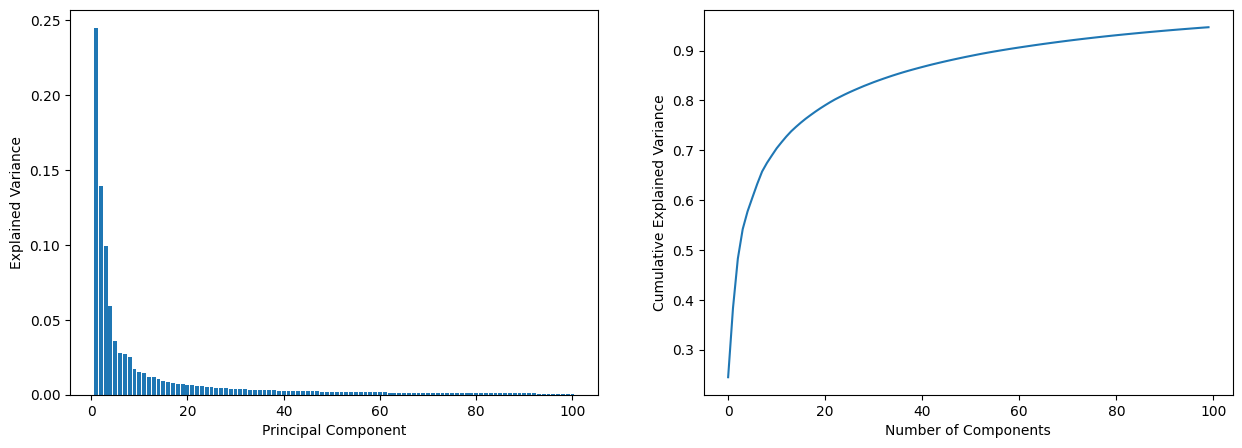

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot explained variance
ax[0].bar(range(1, 101), pca.explained_variance_ratio_)
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Explained Variance')

# Plot cumulative explained variance
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance')

In [127]:
# Select number of components to explain approx. 80% variance
n_components = 20
actual_pca = PCA(n_components=n_components)
actual_scores = actual_pca.fit_transform(J_centered)
actual_components = actual_pca.components_

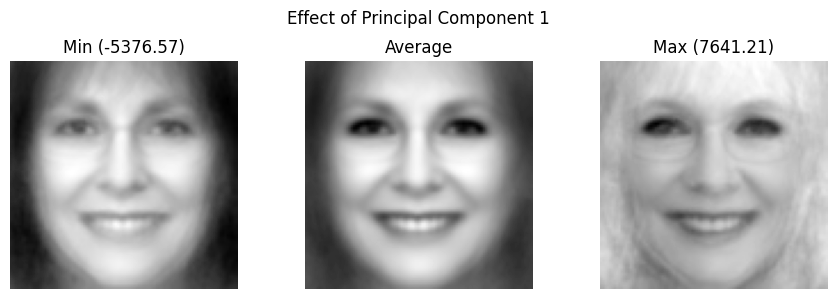

In [128]:
# For PC1, visualize variation
min_score = np.min(actual_scores[:, 0])
max_score = np.max(actual_scores[:, 0])

# Three images: min, mean, max
# Image components weighted by min/max scores added onto the average image shows the effect of that component
img_min = (mean_J + min_score * actual_components[0]).reshape(100, 100)
img_avg = mean_J.reshape(100, 100)
img_max = (mean_J + max_score * actual_components[0]).reshape(100, 100)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))

titles = [f"Min ({min_score:.2f})", "Average", f"Max ({max_score:.2f})"]
imgs = [img_min, img_avg, img_max]

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.suptitle(f"Effect of Principal Component 1")
plt.tight_layout()
plt.show()